In [1]:
from IPython.display import set_matplotlib_formats
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS,Predictive


plt.style.use("bmh")

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(10)
rng_key, rng_key_ = random.split(rng_key)


/home/yousef/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATASET_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv"
dset = pd.read_csv(DATASET_URL, sep=";")
dset.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


<AxesSubplot: xlabel='WaffleHouses', ylabel='Divorce'>

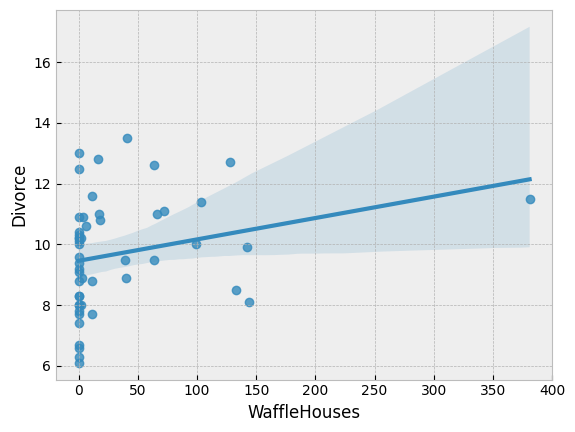

In [3]:
sns.regplot(dset,x="WaffleHouses", y="Divorce")

In [4]:
standardize = lambda x: (x - x.mean()) / x.std()

dset["AgeScaled"] = dset.MedianAgeMarriage.pipe(standardize)
dset["MarriageScaled"] = dset.Marriage.pipe(standardize)
dset["DivorceScaled"] = dset.Divorce.pipe(standardize)


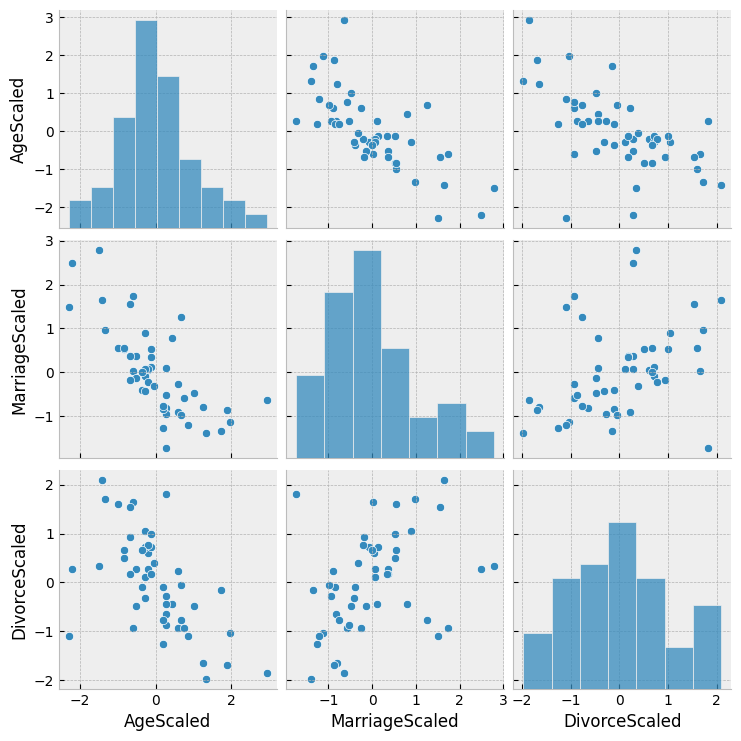

In [5]:
sns.pairplot(dset,vars=["AgeScaled", "MarriageScaled", "DivorceScaled"])

we are going to model divorce conditioned on marriage and median marriage age.
our model is as follows:
$$D \sim  N(\mu, \sigma)$$
$$ \sigma \sim Exp(1) $$
$$ \mu = a + b_M M + b_A A $$


In [6]:
def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    marriage = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    divorce = dset.DivorceScaled.values[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(marriage, mean)
    ax.plot(marriage, divorce, "o")
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax

In [7]:
def model(marriage=None, age=None, divorce=None):
    a = numpyro.sample("a", dist.Normal(0.0, 0.2))
    M, A = 0.0, 0.0
    if marriage is not None:
        bM = numpyro.sample("bM", dist.Normal(0.0, 0.5))
        M = bM * marriage
    if age is not None:
        bA = numpyro.sample("bA", dist.Normal(0.0, 0.5))
        A = bA * age
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + M + A
    error_sigma = numpyro.sample("error_sigma", dist.Exponential(1))
    anomally_prob = numpyro.sample("anomally_prob",dist.Beta(20,5))
    mixing_dist = dist.Categorical(probs=jnp.array([1 - anomally_prob,anomally_prob]))
    component_dists = [dist.Normal(loc=mu, scale=sigma), dist.Normal(loc=0.0, scale=error_sigma)]
    numpyro.sample("obs", dist.MixtureGeneral(mixing_dist, component_dists), obs=divorce)

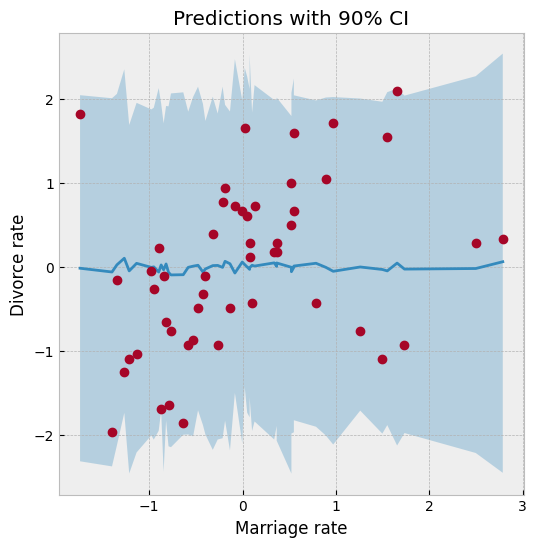

In [8]:
prior_predictive = Predictive(model, num_samples=1000)
prior_predictions = prior_predictive(rng_key_, marriage=dset.MarriageScaled.values)["obs"]
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)
ax = plot_regression(dset.MarriageScaled.values, mean_prior_pred, hpdi_prior_pred)
ax.set(xlabel="Marriage rate", ylabel="Divorce rate", title="Predictions with 90% CI");

sample: 100%|██████████| 3000/3000 [00:04<00:00, 665.96it/s, 7 steps of size 6.24e-01. acc. prob=0.85] 


[Text(0.5, 0, 'Marriage rate'),
 Text(0, 0.5, 'Divorce rate'),
 Text(0.5, 1.0, 'Regression line with 90% CI')]

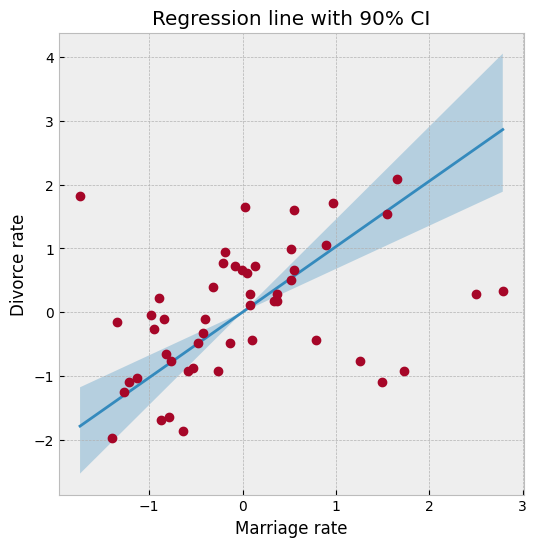

In [9]:
# Run NUTS.
kernel = NUTS(model)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(rng_key_, marriage=dset.MarriageScaled.values, divorce=dset.DivorceScaled.values)
samples_1 = mcmc.get_samples()

# Compute empirical posterior distribution over mu
posterior_mu = jnp.expand_dims(samples_1["bM"], -1) * dset.MarriageScaled.values
mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(dset.MarriageScaled.values, mean_mu, hpdi_mu)
ax.set(xlabel="Marriage rate", ylabel="Divorce rate", title="Regression line with 90% CI")

In [10]:
mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
              a      0.05      0.15      0.05     -0.18      0.29   2074.88      1.00
  anomally_prob      0.72      0.08      0.72      0.61      0.87   1197.55      1.00
             bM      1.03      0.28      1.07      0.68      1.46    739.84      1.00
    error_sigma      0.94      0.14      0.94      0.73      1.18    669.03      1.00
          sigma      0.52      0.22      0.49      0.20      0.88    382.45      1.01

Number of divergences: 0


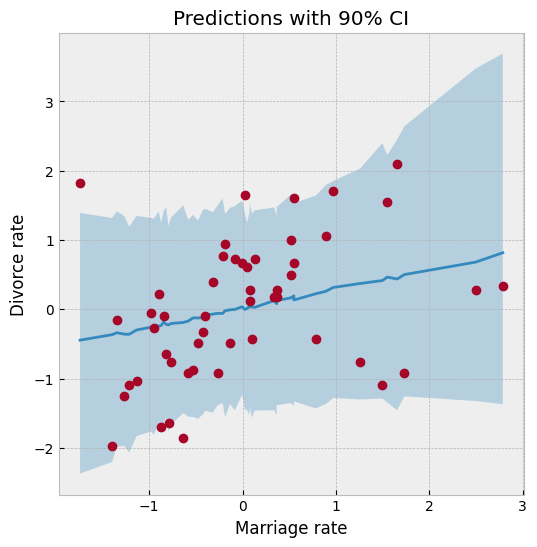

In [11]:
posterior_predictive = Predictive(model,samples_1)
posterior_predictions = posterior_predictive(rng_key_, marriage=dset.MarriageScaled.values)["obs"]
mean_posterior_pred = jnp.mean(posterior_predictions, axis=0)
hpdi_posterior_pred = hpdi(posterior_predictions, 0.9)

ax = plot_regression(dset.MarriageScaled.values, mean_posterior_pred, hpdi_posterior_pred)
ax.set(xlabel="Marriage rate", ylabel="Divorce rate", title="Predictions with 90% CI");